## Machinery

In [16]:
%load_ext watermark
%watermark -i -v -m -p pandas,pystan,arviz

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2021-02-11T00:02:19+08:00

CPython 3.8.6
IPython 7.20.0

pandas 1.2.1
pystan 2.19.1.1
arviz 0.11.0

compiler   : GCC 9.3.0
system     : Linux
release    : 4.4.0-21301-Microsoft
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [17]:
import pandas as pd
import numpy as np
from termcolor import colored
import scipy.stats as ss

%load_ext rpy2.ipython

import isoweek

import os
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
%matplotlib inline
# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D

# Parameters for seaborn plots
import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
set_plot_style()

month_names = ["Unknown", "January", "Febuary", "March", "April", "May", "June", "July", 
               "August", "September", "October", "November", "December"]

%config InlineBackend.figure_format = 'retina'

In [19]:
import pystan
import arviz as az

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames):
    # include mean and hdi
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [20]:
!mkdir -p ../../figures
!mkdir -p ../../figures/draft

standistribdir = '../../../../CmdStan'
stanworkdir = '../../../NTU_Backup/mortality-US_all_states_20210204/reporting_delay-nonparametric'
!mkdir -p {stanworkdir}

In [21]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
num_cores

12

# <font color="purple">Loading the data</font>

In [22]:
datadir = "../../data/mortality"
datafiles = !ls {datadir}/*csv
datafiles

['../../data/mortality/2020W34 (enddate 20200822; updated 20200902) - cdc.csv',
 '../../data/mortality/2020W35 (enddate 20200829; updated 20200909) - cdc.csv',
 '../../data/mortality/2020W37 (enddate 20200912; updated 20200922) - covdata.csv',
 '../../data/mortality/2020W38 (enddate 20200919; updated 20200929) - covdata.csv',
 '../../data/mortality/2020W39 (enddate 20200926; updated 20201006) - covdata.csv',
 '../../data/mortality/2020W40 (enddate 20201003; updated 20201015) - cdc.csv',
 '../../data/mortality/2020W41 (enddate 20201010; updated 20201022) - cdc.csv',
 '../../data/mortality/2020W42 (enddate 20201017; updated 20201029) - cdc.csv',
 '../../data/mortality/2020W43 (enddate 20201024; updated 20201103) - cdc.csv',
 '../../data/mortality/2020W44 (enddate 20201031; updated 20201110) - cdc.csv',
 '../../data/mortality/2020W45 (enddate 20201107; updated 20201119) - cdc.csv',
 '../../data/mortality/2020W46 (enddate 20201114; updated 20201126) - cdc.csv',
 '../../data/mortality/2020W

In [23]:
df = None
for datafile in datafiles:
    df_ = pd.read_csv(datafile)
    df_['source'] = datafile.split('/')[-1].split(' - ')[-1][:-4]
    df_['reporting'] = pd.to_datetime(datafile.split('updated ')[-1].split(') ')[0], format="%Y-%m-%d")
    df = df_ if df is None else df.append(df_)
df['number_of_deaths'] = df['number_of_deaths'].astype(pd.Int64Dtype())
df['week'] = ["%dW%02d"%(x,y) for x,y in zip(df['year'],df['week'])]
df['reporting_week'] = [x.strftime("%YW%V") for x in df['reporting']]
df = df.loc[:, ['jurisdiction', 'week', 'number_of_deaths', 'reporting_week']]
# removing United States
df = df.loc[lambda d: (d.jurisdiction!='United States')]
print(df['reporting_week'].unique())
df[:5]

['2020W36' '2020W37' '2020W39' '2020W40' '2020W41' '2020W42' '2020W43'
 '2020W44' '2020W45' '2020W46' '2020W47' '2020W48' '2020W49' '2020W50'
 '2020W51' '2020W52' '2020W53' '2021W01' '2021W02' '2021W03' '2021W04'
 '2021W05']


,jurisdiction,week,number_of_deaths,reporting_week
0,Alabama,2020W01,1077,2020W36
1,Alabama,2020W02,1124,2020W36
2,Alabama,2020W03,1038,2020W36
3,Alabama,2020W04,1053,2020W36
4,Alabama,2020W05,1023,2020W36


In [24]:
all_jurisdictions = df.jurisdiction.unique().astype('str')
all_jurisdictions

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'New York City',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='<U20')

In [25]:
def getData(df, jurisdictions_to_remove, weekmin):
    jurisdictions_to_keep = [x for x in all_jurisdictions if x not in jurisdictions_to_remove]
    # df with jurisdiction
    df_index_jurisdictions = pd.DataFrame({'jurisdiction': jurisdictions_to_keep}).reset_index().rename(columns={'index': 'idx_jurisdiction'})
    df_index_jurisdictions['idx_jurisdiction'] += 1
    # df with snapshots
    X = df.reporting_week.unique()
    snapshots = np.sort([x for x in X if ((int(x.split("W")[-1])>=weekmin)&(int(x.split("W")[0])==2020))|(int(x.split("W")[0])!=2020)])
    df_index_snapshots = pd.DataFrame({'reporting_week': snapshots}).sort_values('reporting_week').reset_index(drop=True).reset_index().rename(columns={'index': 'idx_snapshot'})
    df_index_snapshots['idx_snapshot'] += 1
    
    df_ = df.copy().merge(df_index_jurisdictions, on='jurisdiction', how='right')
    
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    # for wide format
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    df_ = df_\
        .loc[:,['idx_jurisdiction','week','number_of_deaths','reporting_week']]\
        .sort_values(['idx_jurisdiction','week','reporting_week'])\
        .merge(df_index_snapshots, on='reporting_week', how='left')
    df_['idx_snapshot'] = df_.idx_snapshot.astype(pd.Int64Dtype())
    df_ = df_.pivot_table(index=['idx_jurisdiction','idx_snapshot'], values=['number_of_deaths'], 
            columns=['week'], fill_value=0) # zeros are for both zero counts and NAs since they won't affect our fit 

    return df_, df_index_jurisdictions, df_index_snapshots

df_reporting_delay__, df_index_jurisdictions__, df_index_snapshots__ = getData(df, ['Alabama'], 26)
print(df_index_jurisdictions__.loc[lambda d: d.jurisdiction=='North Carolina'])
df_reporting_delay__.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==34]

    idx_jurisdiction    jurisdiction
33                34  North Carolina


number_of_deaths                          \
week                                   2020W01 2020W02 2020W03 2020W04   
idx_jurisdiction idx_snapshot                                            
34               1                        2003    1984    1901    1993   
                 2                        2003    1985    1901    1993   
                 3                        2004    1985    1901    1993   
                 4                        2004    1985    1901    1993   
                 5                        2004    1985    1901    1993   
                 6                        2004    1985    1901    1993   
                 7                        2003    1983    1900    1993   
                 8                        2003    1983    1901    1993   
                 9                        2003    1983    1901    1993   
                 10                       2003    1983    1901    1993   
                 11                       2003    1983    1901    1993   
                 12                       2003    1983    1901    1993   
                 13                       2003    1983    1901    1993   
                 14                       2003    1983    1901    1993   
                 15                       2003    1983    1901    1993   
                 16                       2003    1983    1901    1993   
                 17                       2003    1983    1901    1993   
                 18                       2003    1983    1901    1993   
                 19                       2003    1983    1901    1993   
                 20                       2003    1983    1901    1993   
                 21                       2003    1983    1901    1993   
                 22                       2003    1983    1901    1993   

                                                                               \
week                          2020W05 2020W06 2020W07 2020W08 2020W09 2020W10   
idx_jurisdiction idx_snapshot                                                   
34               1               1984    2055    2061    1926    1968    2033   
                 2               1984    2055    2061    1926    1968    2033   
                 3               1984    2055    2061    1926    1970    2034   
                 4               1984    2055    2061    1926    1970    2034   
                 5               1984    2055    2061    1926    1970    2034   
                 6               1984    2055    2061    1926    1970    2034   
                 7               1983    2053    2060    1924    1973    2030   
                 8               1983    2053    2060    1925    1973    2031   
                 9               1983    2053    2060    1925    1973    2031   
                 10              1983    2053    2060    1925    1973    2031   
                 11              1983    2053    2060    1925    1973    2031   
                 12              1983    2053    2060    1925    1973    2031   
                 13              1983    2053    2060    1925    1974    2031   
                 14              1983    2053    2060    1925    1974    2031   
                 15              1983    2053    2060    1925    1974    2031   
                 16              1983    2053    2060    1925    1974    2032   
                 17              1983    2053    2060    1925    1974    2032   
                 18              1983    2053    2060    1925    1974    2032   
                 19              1983    2053    2060    1925    1972    2032   
                 20              1983    2053    2060    1925    1972    2032   
                 21              1983    2053    2060    1925    1972    2032   
                 22              1983    2053    2060    1925    1972    2032   

                               ...                                          \
week                           ... 2020W44 2020W45 2020W46 2020W47 2020W48 

In [26]:
df, df_index_jurisdictions, df_index_snapshots = getData(df, [], 26)

In [28]:
df_minus_1 = df.loc[lambda d: d.index.get_level_values("idx_snapshot")==max(df.index.get_level_values("idx_snapshot").values)]\
    .loc[lambda d: (d == -1).any(axis=1)]
df_minus_1

Empty DataFrame
Columns: [(number_of_deaths, 2020W01), (number_of_deaths, 2020W02), (number_of_deaths, 2020W03), (number_of_deaths, 2020W04), (number_of_deaths, 2020W05), (number_of_deaths, 2020W06), (number_of_deaths, 2020W07), (number_of_deaths, 2020W08), (number_of_deaths, 2020W09), (number_of_deaths, 2020W10), (number_of_deaths, 2020W11), (number_of_deaths, 2020W12), (number_of_deaths, 2020W13), (number_of_deaths, 2020W14), (number_of_deaths, 2020W15), (number_of_deaths, 2020W16), (number_of_deaths, 2020W17), (number_of_deaths, 2020W18), (number_of_deaths, 2020W19), (number_of_deaths, 2020W20), (number_of_deaths, 2020W21), (number_of_deaths, 2020W22), (number_of_deaths, 2020W23), (number_of_deaths, 2020W24), (number_of_deaths, 2020W25), (number_of_deaths, 2020W26), (number_of_deaths, 2020W27), (number_of_deaths, 2020W28), (number_of_deaths, 2020W29), (number_of_deaths, 2020W30), (number_of_deaths, 2020W31), (number_of_deaths, 2020W32), (number_of_deaths, 2020W33), (number_of_deaths, 2020W34), (number_of_deaths, 2020W35), (number_of_deaths, 2020W36), (number_of_deaths, 2020W37), (number_of_deaths, 2020W38), (number_of_deaths, 2020W39), (number_of_deaths, 2020W40), (number_of_deaths, 2020W41), (number_of_deaths, 2020W42), (number_of_deaths, 2020W43), (number_of_deaths, 2020W44), (number_of_deaths, 2020W45), (number_of_deaths, 2020W46), (number_of_deaths, 2020W47), (number_of_deaths, 2020W48), (number_of_deaths, 2020W49), (number_of_deaths, 2020W50), (number_of_deaths, 2020W51), (number_of_deaths, 2020W52), (number_of_deaths, 2020W53)]
Index: []

[0 rows x 53 columns]

## All regions

In [62]:
## stan code
stan_code = """
data {
    int<lower = 1> S; // number of snapshots
    int<lower = 1> W; // max week number
    int<lower = 1> Wmax[S];
    int<lower = 0, upper=(S-1)*W> N_masked; // total number of masked records in the dataset

    int<lower = -1> deaths[S, W]; // deaths counts (-1 means that the count was masked by CDC)

    int<lower = 1> T[S]; // vector of a publishing week for each snapshot
    int<lower = 1> M; // number of points for calculation of the likelihood
    
    int<lower = 1> D; // max delay
}

transformed data {
    int deaths0[W];

    for (w in 1:W)
        deaths0[w] = deaths[S, w];
}

parameters {
    vector<lower = 0, upper = 1>[D] gd;
    
    vector<lower = 1, upper = 9>[N_masked] deaths_masked;
}

model {
    gd ~ normal(0.5, 2.0);

    matrix[S-1, W] deaths_with_imputed = to_matrix(deaths[1:(S-1), 1:W]);
    int kk = 0;
    for (s in 1:S-1) {
        vector[Wmax[s]] mu_t;
        for (w in T[s]-D-1:Wmax[s]) {
            if (deaths_with_imputed[s, w]==-1) {
                kk += 1;
                deaths_with_imputed[s, w] = deaths_masked[kk];
            }
            mu_t[w] = ((T[S] - w - 1 > D) ? 1.0 : prod(1 - gd[(T[S] - w - 1):D])) / ((T[s] - w - 1 > D) ? 1.0 : prod(1 - gd[(T[s] - w - 1):D]));
        }
        target += poisson_lupmf(deaths0[T[s]-D-1:Wmax[s]] | to_vector(deaths_with_imputed[s, T[s]-D-1:Wmax[s]]) .* mu_t[T[s]-D-1:Wmax[s]] + 1e-8);
    }
}

generated quantities {
    vector[D+1] fd;
    fd[1] = prod(1 - gd[1:D]);
    for (d in 1:D-1)
        fd[d+1] = gd[d]*prod(1 - gd[(d+1):D]);
    fd[D+1] = gd[D];
    
    real mean_delay = fd[1];
    for (d in 1:D)
        mean_delay += (d+2)*fd[d+1];
        
    int deaths_pred[W];
    {
        real F;
        for (w in 1:W) {
            F = ((T[S] - w - 1 > D) ? 1.0 : prod(1 - gd[(T[S] - w - 1):D]));
            deaths_pred[w] = deaths0[w] + neg_binomial_2_rng(deaths0[w] * (1.0 - F) / F + 1e-8, deaths0[w]);
        }
    }
}
"""

In [63]:
#### bash file
def bash_file(stanscriptdir):
    return """#!/bin/bash
cwd=$(pwd)
cd """+standistribdir+"""
make -j4 """+stanscriptdir+"""/fit
cd """+stanscriptdir+"""
mkdir -p diagnostics
for i in {1..4}
do
    echo Running ${i}
    ID=$((0+$i))
    SEEDNUMBER=$((0+${ID}))
    ./fit \\
        method=sample num_samples=2500 num_warmup=10000 thin=1 save_warmup=0 \\
        random seed=${SEEDNUMBER} \\
        id=$i \\
        data file=Data.R \\
        init=Init.R \\
        output file=trace-${ID}.csv refresh=2000\\
            diagnostic_file=diagnostics/diagnostics-${ID}.csv > diagnostics/output-${ID}.txt &
done
echo Finished haha!
"""

In [64]:
def compile_model(idx_jurisdiction):
    # idxs_jurisdictions should start from 1 and be a range to the maximal value
    standirname = stanworkdir+'/nonparametric_region-%02d'%idx_jurisdiction
    !mkdir -p {standirname}
    
    stanscriptdir = '../Dropbox/'+standirname[9:]
    
    df_ = df.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==idx_jurisdiction]

    snapshots = df_index_snapshots.reporting_week.values
    df_index_jurisdictions.to_pickle(standirname+"/idx_jurisdictions.pkl")
    df_index_snapshots.to_pickle(standirname+"/idx_snapshots.pkl")
    df_.to_pickle(standirname+"/df_deaths_counts.pkl")
    
    Deaths = df_.values

    # maximal non-zero week for given jurisdiction and snapshot
    ## +1 because the index count of an array starts from 1 in Stan, but from 0 in Python
    weekmax = [np.max(np.nonzero(x)) + 1 for x in Deaths]
    weeks = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in df_.columns.get_level_values("week")]]

    # data file
    stan_data = dict({
        'T': [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in df_index_snapshots.set_index('idx_snapshot')\
             .loc[df_.index.get_level_values('idx_snapshot').unique()]\
             .sort_values('reporting_week').reporting_week.values]],
        'W': len(weeks),
        'S': len(snapshots),
        'Wmax': weekmax,
        'M': np.sum(weekmax[:-1]),
        # observed death counts
        'deaths': Deaths,
        # number of masked deaths counts
        'N_masked': np.sum(np.transpose(df_.values)[...,:-1]==-1),
        'D': 20,
        'deaths_masked_upper': 9
    })
    pystan.misc.stan_rdump(stan_data, standirname+'/Data.R')

    stan_init = dict({
        'deaths_unobs': 5.0*np.ones((stan_data['N_masked']), dtype='float')
    })
    pystan.misc.stan_rdump(stan_init, standirname+'/Init.R')
    stan_init;

    # stan code
    f = open(standirname+"/fit.stan", "w")
    f.write(stan_code)
    f.close()

    # bash file
    f = open(standirname+"/fit_bash.sh", "w")
    f.write(bash_file(stanscriptdir))
    f.close()

    # compilation
    !rm -f {standirname+"/fit"}
    os.system("bash "+standirname+"/fit_bash.sh")
    
    return True

In [65]:
import time
for idx_ in df_index_jurisdictions.idx_jurisdiction.values:
# for idx_ in [df_index_jurisdictions.idx_jurisdiction.values[x]-1 for x in [1]]: #[ 5  7 10 23 26 45 49 52]
    print(colored(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==idx_].jurisdiction.values[0],'red'))
    compile_model(idx_)
    #time.sleep(60)

Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
New York City
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Puerto Rico
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


### Post-processing

In [68]:
dirs = !ls {stanworkdir}

In [69]:
df_index_jurisdictions.loc[lambda d: d.jurisdiction=='North Carolina']

,idx_jurisdiction,jurisdiction
34,35,North Carolina


In [70]:
df_output = None
clrs = ['red', 'green', 'blue']
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    folder = 'nonparametric_region-%02d'%region
    posterior_glob = !cd "{stanworkdir}/{folder}"; ls trace-*
    print(colored(folder + " | " + "number of chains: %d"%len(posterior_glob), clrs[region%3]))
    cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+folder+"/"+x for x in posterior_glob], log_likelihood='llk') 
    output0 = get_stats_2d(cmdstan_data,['mean_delay','fd']).rename(columns={'time':'d'})
    output0['idx_jurisdiction'] = int(folder.split("-")[-1])
    output0['folder'] = folder
    df_output = output0 if df_output is None else df_output.append(output0)
df_output

nonparametric_region-01 | number of chains: 4
nonparametric_region-02 | number of chains: 4
nonparametric_region-03 | number of chains: 4
nonparametric_region-04 | number of chains: 4
nonparametric_region-05 | number of chains: 4
nonparametric_region-06 | number of chains: 4
nonparametric_region-07 | number of chains: 4
nonparametric_region-08 | number of chains: 4
nonparametric_region-09 | number of chains: 4
nonparametric_region-10 | number of chains: 4
nonparametric_region-11 | number of chains: 4
nonparametric_region-12 | number of chains: 4
nonparametric_region-13 | number of chains: 4
nonparametric_region-14 | number of chains: 4
nonparametric_region-15 | number of chains: 4
nonparametric_region-16 | number of chains: 4
nonparametric_region-17 | number of chains: 4
nonparametric_region-18 | number of chains: 4
nonparametric_region-19 | number of chains: 4
nonparametric_region-20 | number of chains: 4
nonparametric_region-21 | number of chains: 4
nonparametric_region-22 | number o

,var,d,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,idx_jurisdiction,folder
0,mean_delay,NA,2.804,2.743,2.782,2.825,2.867,2.743,2.783,2.804,2.825,2.867,10863.0,9346.0,1.0,1,nonparametric_region-01
1,fd,0,0.488,0.481,0.486,0.490,0.494,0.481,0.485,0.488,0.490,0.494,11859.0,9022.0,1.0,1,nonparametric_region-01
2,fd,1,0.221,0.210,0.217,0.225,0.232,0.210,0.217,0.221,0.224,0.232,9161.0,7203.0,1.0,1,nonparametric_region-01
3,fd,2,0.115,0.102,0.111,0.120,0.129,0.102,0.111,0.115,0.120,0.128,8481.0,6491.0,1.0,1,nonparametric_region-01
4,fd,3,0.094,0.080,0.089,0.099,0.108,0.080,0.089,0.094,0.099,0.108,7394.0,6741.0,1.0,1,nonparametric_region-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,fd,16,0.002,0.000,0.000,0.001,0.006,0.000,0.001,0.001,0.003,0.007,7586.0,4415.0,1.0,53,nonparametric_region-53
18,fd,17,0.002,0.000,0.000,0.002,0.006,0.000,0.001,0.002,0.003,0.008,7829.0,4523.0,1.0,53,nonparametric_region-53
19,fd,18,0.002,0.000,0.000,0.001,0.006,0.000,0.001,0.001,0.003,0.007,7633.0,3967.0,1.0,53,nonparametric_region-53
20,fd,19,0.002,0.000,0.000,0.002,0.006,0.000,0.001,0.002,0.003,0.008,6946.0,4172.0,1.0,53,nonparametric_region-53


In [71]:
df_output = df_output.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')

In [72]:
# the r-hat for Weibull in New Hampshire and Maine are not good because that jurisdiction report quite well 
# and it is difficult to fit 
df_output.loc[lambda d: d.r_hat>1.1]

,var,d,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,idx_jurisdiction,folder,jurisdiction


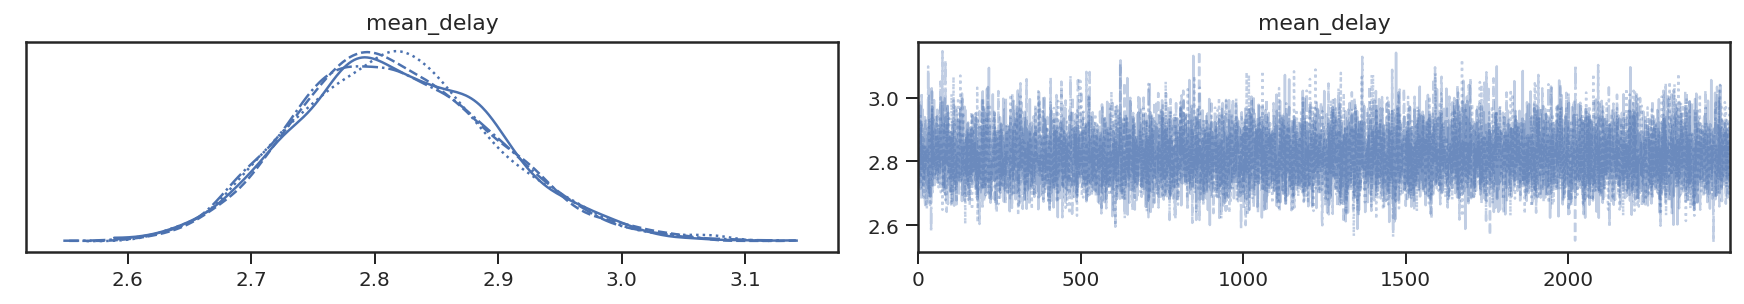

In [73]:
az.plot_trace(cmdstan_data, var_names=['mean_delay']);

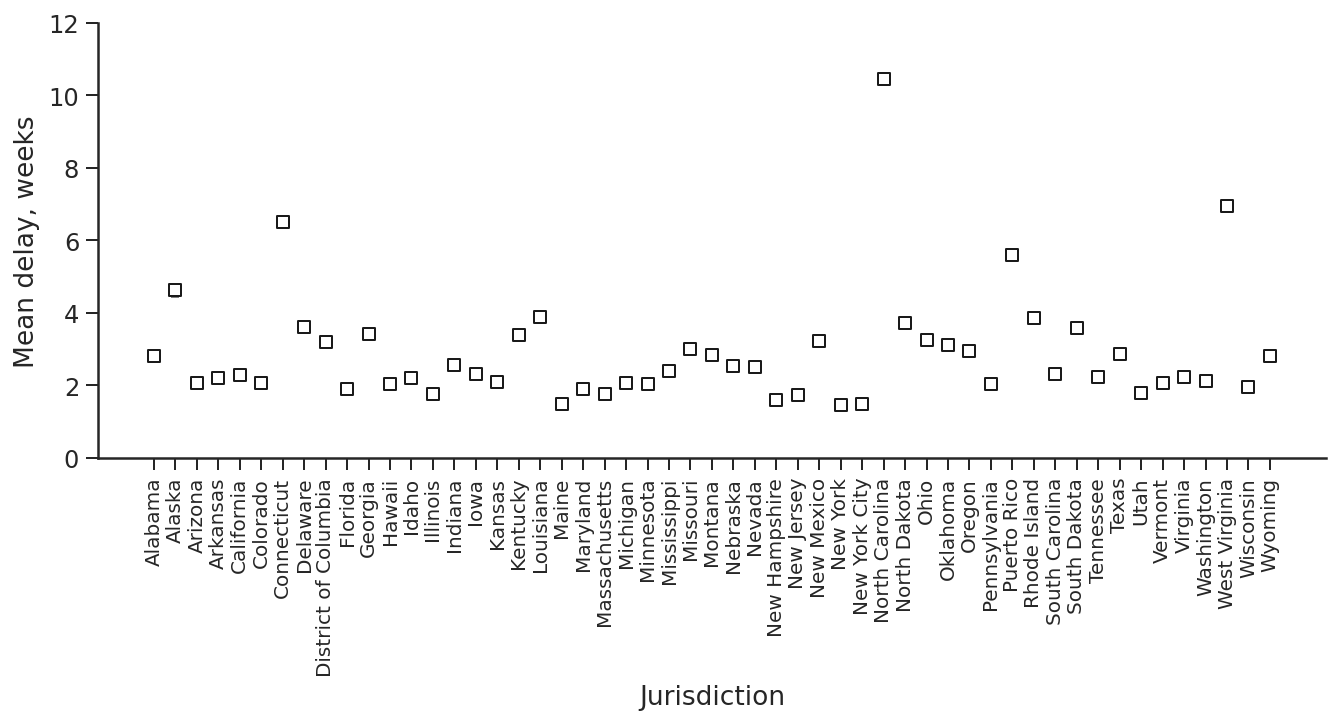

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 4)
for idx0_, var_ in enumerate(['mean_delay', 'mean_delay_without_zero']):
    df_output_ = df_output.loc[lambda d: (d['var']==var_)].sort_values('jurisdiction')
    X = df_output_.jurisdiction
    
    if idx0_==0:
        ax.errorbar(X, .5*(df_output_['q25']+df_output_['q75']), .5*(df_output_['q75']-df_output_['q25']), linewidth=3.25,
                    color='grey', linestyle='None', zorder=-4)
        ax.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
                    color='grey', linestyle='None', zorder=-5)
        ax.scatter(X, df_output_['median'], marker='s', edgecolor='k', alpha=1, facecolor='w', s=40); 
    else:
        ax.scatter(X, df_output_['median'], marker='x', color='k', alpha=1); 
        
# ax.set_yticks(np.arange(0,ylms[idx0_]+2,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
plt.xticks(rotation='vertical', fontsize=10);
ax.set_xlabel('Jurisdiction')
ax.set_ylabel('Mean delay, weeks')
ax.set_ylim(bottom=0,top=12)